<h1><center> <font color='black'> Business Data Analytics - Practice Session_06 </font></center></h1>
<h2><center> <font color='black'> Model Evaluation - Classification</font></center></h3>
<h2><center> <font color='black'> University of Tartu - Spring 2020</font></center></h3>

* In today’s lab session we will explore data about processed by travel agency claims. Based on this data we will try to predict either the claim will be accepted or rejected. We will use various metrics to `(evaluate)` measure the performance of our classification model.


* Outline:
    * Data preprocessing and understanding
    * Building a classification model using XGBoost classifier
    * Imbalanced data set
    * Evaluation metrics (accuracy, confusion matrix, precision, recall, AUC, and logLoss)
    * K-Fold Cross Validation



#### Load the required packages.

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # For creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt
%matplotlib inline


#Let's make this notebook reproducible, you can use any number ex = 42
np.random.seed(42)


# set plot style for all plots
plt.style.use('ggplot')
%matplotlib inline


# https://www.webucator.com/blog/2015/03/python-color-constants-module/

# Data preprocessing and understanding

#### Loading the data

* Our dataset contains details about the claim, which we will use to predict their status (approved or not).

In [7]:
# read travel insurence df
travel = pd.read_csv('travel_insurance.csv')
travel.head()

,Agency,Agency.Type,Distribution.Channel,Product.Name,Claim,Duration,Destination,Net.Sales,Commision..in.value.,Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
1,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,-1,AUSTRALIA,-49.5,29.70,NaN,32
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,47,UNITED STATES,-39.6,23.76,NaN,32
4,JZI,Airlines,Online,Basic Plan,No,33,"KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF",-26.0,9.10,NaN,118


* **Target:** Claim Status `(Claim)`
* Name of agency `(Agency)`
* Type of travel insurance agencies `(Agency.Type)`
* Distribution channel of travel insurance agencies `(Distribution.Channel)`
* Name of the travel insurance products `(Product.Name)`
* Duration of travel `(Duration)`
* Destination of travel `(Destination)`
* Amount of sales of travel insurance policies `(Net.Sales)`
* Commission received for travel insurance agency `(Commission)`
* Gender of insured `(Gender)`
* Age of insured `(Age)`


In [8]:
travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19659 entries, 0 to 19658
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                19659 non-null  object 
 1   Agency.Type           19659 non-null  object 
 2   Distribution.Channel  19659 non-null  object 
 3   Product.Name          19659 non-null  object 
 4   Claim                 19659 non-null  object 
 5   Duration              19659 non-null  int64  
 6   Destination           19659 non-null  object 
 7   Net.Sales             19659 non-null  float64
 8   Commision..in.value.  19659 non-null  float64
 9   Gender                5958 non-null   object 
 10  Age                   19659 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 1.6+ MB


* Looking at the above output we can see that `gender` has many missing values, let's deep into this column.

In [9]:
# count values for gender column
print(f"Gender column (Male, or Female):\n{travel['Gender'].value_counts()}\n")

# count the missing values for gender column:
print(f"Gender column missing values: \"{travel['Gender'].isnull().sum()}\"")

Gender column (Male, or Female):
M    3038
F    2920
Name: Gender, dtype: int64

Gender column missing values: "13701"


In [41]:
colors = [ '#66CDAA','#66CD00',  '#6495ED']

ax = travel['Gender'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3, colors=colors)
ax.set_ylabel('# of type')
ax.set_title('# of Male/Female')

# create a list to collect the plt.patches data
# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}'.format((height)), (p.get_x()+.12*width, p.get_y()+.8*height),
                color = 'white',
               weight = 'bold',
               size = 14)

KeyError: 'Gender'

In [11]:
# get the percent of missing values
print(f"Gender column missing values percent: {travel['Gender'].isna().mean().round(4) * 100}%")


Gender column missing values percent: 69.69%


* As you can see, we have ~30% of the data where gender is defined. This give us 2 possible ways of dealing with the problem:

    1 - Remove all rows where Gender is NA (Leaves us ~30% of the current data);
    
    2 - Comeplitely exclude the feature from our model.
    

* In this case, we will pick the 2nd option.

In [12]:
del travel['Gender']

In [13]:
travel.head()

,Agency,Agency.Type,Distribution.Channel,Product.Name,Claim,Duration,Destination,Net.Sales,Commision..in.value.,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,71
1,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,-1,AUSTRALIA,-49.5,29.70,32
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,47,UNITED STATES,-39.6,23.76,32
4,JZI,Airlines,Online,Basic Plan,No,33,"KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF",-26.0,9.10,118


In [14]:
travel.info()
travel.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19659 entries, 0 to 19658
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                19659 non-null  object 
 1   Agency.Type           19659 non-null  object 
 2   Distribution.Channel  19659 non-null  object 
 3   Product.Name          19659 non-null  object 
 4   Claim                 19659 non-null  object 
 5   Duration              19659 non-null  int64  
 6   Destination           19659 non-null  object 
 7   Net.Sales             19659 non-null  float64
 8   Commision..in.value.  19659 non-null  float64
 9   Age                   19659 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 1.5+ MB


Agency                  0
Agency.Type             0
Distribution.Channel    0
Product.Name            0
Claim                   0
Duration                0
Destination             0
Net.Sales               0
Commision..in.value.    0
Age                     0
dtype: int64

* descriptive analysis

In [15]:
travel.describe()

,Duration,Net.Sales,Commision..in.value.,Age
count,19659.000000,19659.000000,19659.000000,19659.000000
mean,51.041406,42.618855,10.322429,39.868508
std,91.733459,52.443277,20.455509,13.883582
min,-1.000000,-291.750000,0.000000,0.000000
25%,10.000000,18.000000,0.000000,35.000000
50%,23.000000,27.000000,0.000000,36.000000
75%,54.000000,49.500000,11.880000,43.000000
max,4844.000000,682.000000,262.760000,118.000000


* Looking at the above data we can see that `Duration` column has negative values and we should deal with this problem. 

* Looking at the above data we can see that `Net.Sales` column has negative values and we should deal with this problem.

* Also `age` column has Max age of 118. A bit suspicios, since [current oldest living person is 114-year old](https://en.wikipedia.org/wiki/Oldest_people)

In [16]:
# Age: filter age 
travel = travel[travel.Age <=114]
travel.Age

0        71
1        32
2        32
3        32
5        53
         ..
19654    48
19655    44
19656    25
19657    51
19658    57
Name: Age, Length: 19367, dtype: int64

In [17]:
# Duration: filter negative values
travel = travel[travel.Duration > 0]
travel.Duration

0        186
2         60
3         47
5          6
6          3
        ... 
19654     60
19655     59
19656     42
19657     10
19658      2
Name: Duration, Length: 19358, dtype: int64

In [18]:
# Net.Sales: filter neg values
travel = travel[travel['Net.Sales'] > 0]
travel['Net.Sales']

7         94.00
8        294.75
9          9.90
10         9.90
11        69.30
          ...  
19654      2.64
19655     22.00
19656     22.00
19657     35.00
19658     18.00
Name: Net.Sales, Length: 18581, dtype: float64

In [19]:
travel.head()

,Agency,Agency.Type,Distribution.Channel,Product.Name,Claim,Duration,Destination,Net.Sales,Commision..in.value.,Age
7,C2B,Airlines,Online,Bronze Plan,Yes,12,SINGAPORE,94.00,23.50,34
8,C2B,Airlines,Online,Silver Plan,No,190,SINGAPORE,294.75,73.69,26
9,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,29,UNITED STATES,9.90,5.94,33
10,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,28,UNITED STATES,9.90,5.94,33
11,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,153,JAPAN,69.30,41.58,35


In [20]:
travel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18581 entries, 7 to 19658
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                18581 non-null  object 
 1   Agency.Type           18581 non-null  object 
 2   Distribution.Channel  18581 non-null  object 
 3   Product.Name          18581 non-null  object 
 4   Claim                 18581 non-null  object 
 5   Duration              18581 non-null  int64  
 6   Destination           18581 non-null  object 
 7   Net.Sales             18581 non-null  float64
 8   Commision..in.value.  18581 non-null  float64
 9   Age                   18581 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 1.6+ MB


In [21]:
travel.isnull().sum()

Agency                  0
Agency.Type             0
Distribution.Channel    0
Product.Name            0
Claim                   0
Duration                0
Destination             0
Net.Sales               0
Commision..in.value.    0
Age                     0
dtype: int64

### More data exploration

In [22]:
## What about the number of claims approved, and/or what can we say about our target variable?
travel['Claim'].value_counts()

No     17667
Yes      914
Name: Claim, dtype: int64

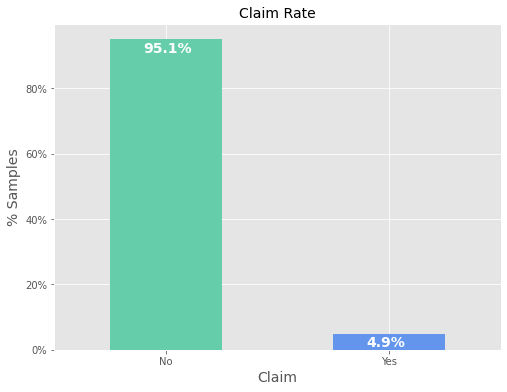

In [23]:
colors = [ '#66CDAA',  '#6495ED']
ax = (travel['Claim'].value_counts()*100.0 /len(travel)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors,
                                                                         figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Samples',size = 14)
ax.set_xlabel('Claim',size = 14)
ax.set_title('Claim Rate', size = 14)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold',
           size = 14)

In [24]:
travel.head()

,Agency,Agency.Type,Distribution.Channel,Product.Name,Claim,Duration,Destination,Net.Sales,Commision..in.value.,Age
7,C2B,Airlines,Online,Bronze Plan,Yes,12,SINGAPORE,94.00,23.50,34
8,C2B,Airlines,Online,Silver Plan,No,190,SINGAPORE,294.75,73.69,26
9,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,29,UNITED STATES,9.90,5.94,33
10,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,28,UNITED STATES,9.90,5.94,33
11,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,153,JAPAN,69.30,41.58,35


In [25]:
target_count = travel.Claim.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])


Class 0: 17667
Class 1: 914


1. The metric trap

    * One of the major issues that users fall into when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like `accuracy_score` can be misleading. In a dataset with highly unbalanced classes, if the classifier always `predicts` the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.


2. Let's do this experiment, using simple `cross-validation` and no feature engineering:


### prepare data for the model

In [26]:
travel.head()

,Agency,Agency.Type,Distribution.Channel,Product.Name,Claim,Duration,Destination,Net.Sales,Commision..in.value.,Age
7,C2B,Airlines,Online,Bronze Plan,Yes,12,SINGAPORE,94.00,23.50,34
8,C2B,Airlines,Online,Silver Plan,No,190,SINGAPORE,294.75,73.69,26
9,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,29,UNITED STATES,9.90,5.94,33
10,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,28,UNITED STATES,9.90,5.94,33
11,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,153,JAPAN,69.30,41.58,35


In [27]:
#Convertin the predictor variable in a binary numeric variable
travel['Claim'].replace(to_replace='Yes', value=1, inplace=True)
travel['Claim'].replace(to_replace='No',  value=0, inplace=True)
travel.head()

# select random important features
Feature = travel[['Duration', 'Distribution.Channel', 'Net.Sales',  'Age']]

# get numeric data for categorical data
Feature = pd.concat([Feature,pd.get_dummies(travel['Distribution.Channel'])], axis=1)

# Features
X = Feature[['Duration', 'Net.Sales', 'Age', 'Offline','Online']]


# Target label, 
y = travel['Claim']




# Building XGBoost model

In [31]:
# !pip install xgboost

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split data to train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

# get an instance from the clf
model = XGBClassifier()

# fit data
model.fit(X_train, y_train)

# predict unseen data
y_pred = model.predict(X_test)

# get accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.60%


Now let's run the same code, but using only one feature (which should drastically reduce the accuracy of the classifier):

In [80]:
X_train

,Duration,Net.Sales,Age,Offline,Online
5339,6,20.0,35,0,1
14805,153,96.0,36,0,1
17410,28,20.0,36,0,1
9687,53,65.0,25,0,1
5778,89,42.0,31,0,1
...,...,...,...,...,...
6732,3,10.0,36,0,1
16192,66,72.0,34,0,1
12105,33,138.6,38,0,1
1794,17,32.0,22,0,1


In [81]:
model = XGBClassifier()

# fir the model using only one feature
model.fit(X_train[['Age']], y_train)
y_pred = model.predict(X_test[['Age']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 95.21%


* As we can see, the high accuracy rate was just an illusion. `In this way, the choice of the metric used in unbalanced datasets is extremely important`.


# How to deal with unbalanced data set


## Resampling

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).


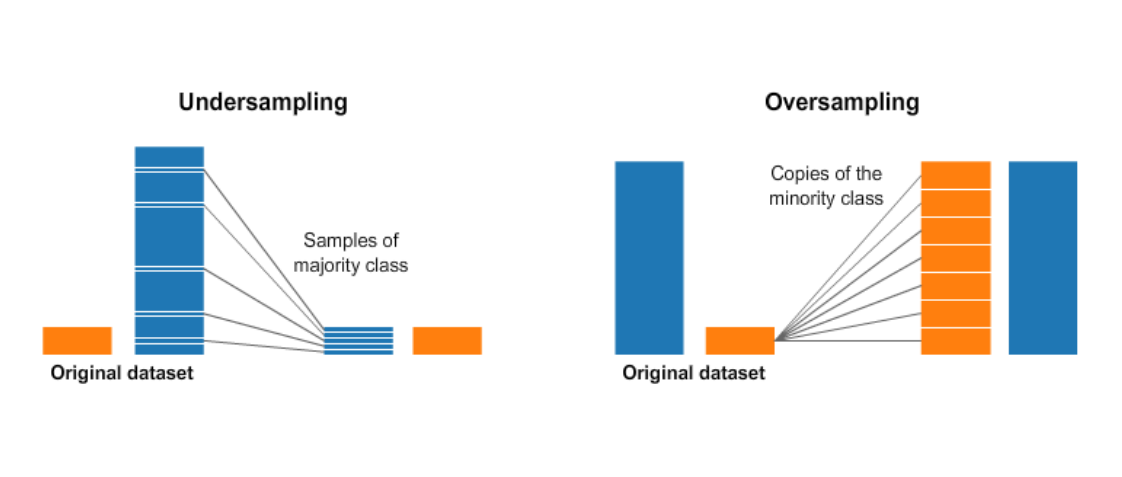

In [82]:
from IPython.display import Image
Image(filename='resampling.png') 

# source: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

* Despite the advantage of balancing classes, these techniques also have their weaknesses `(there is no free lunch).` The simplest implementation of **over-sampling** is to duplicate random records from the minority class, which can cause overfitting. In **under-sampling**, the simplest technique involves removing random records from the majority class, which can cause loss of information.



In [34]:
# Classes count
count_class_0, count_class_1 = travel.Claim.value_counts()

# Divide by class
df_class_0 = travel[travel['Claim'] == 0]
df_class_1 = travel[travel['Claim'] == 1]



## Random under-sampling

In [36]:
# !pip install Rectangle

    Running setup.py install for Rectangle ... done


Random under-sampling:
1    914
0    914
Name: Claim, dtype: int64


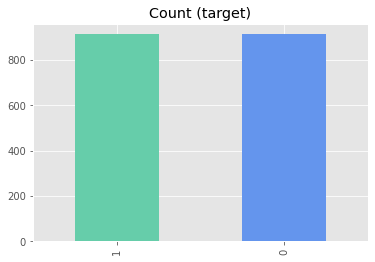

In [42]:
colors = [ '#66CDAA',  '#6495ED']


df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Claim.value_counts())

df_test_under.Claim.value_counts().plot(kind='bar', title='Count (target)',color=colors);

In [43]:
df_test_under.head()

,Agency,Agency.Type,Distribution.Channel,Product.Name,Claim,Duration,Destination,Net.Sales,Commision..in.value.,Age
8706,EPX,Travel Agency,Online,Cancellation Plan,0,7,MYANMAR,15.0,0.00,36
8779,EPX,Travel Agency,Online,Cancellation Plan,0,32,MALAYSIA,10.0,0.00,36
15791,EPX,Travel Agency,Online,1 way Comprehensive Plan,0,2,CHINA,24.0,0.00,36
10498,C2B,Airlines,Online,Silver Plan,0,29,SINGAPORE,84.5,21.13,24
12858,EPX,Travel Agency,Online,Cancellation Plan,0,47,CHINA,22.0,0.00,36


In [44]:
#Convertin the predictor variable in a binary numeric variable
df_test_under['Claim'].replace(to_replace='Yes', value=1, inplace=True)
df_test_under['Claim'].replace(to_replace='No',  value=0, inplace=True)
df_test_under.head()

Feature = df_test_under[['Duration', 'Distribution.Channel', 'Net.Sales',  'Age']]
Feature = pd.concat([Feature,pd.get_dummies(df_test_under['Distribution.Channel'])], axis=1)
X = Feature[['Duration', 'Net.Sales', 'Age', 'Offline','Online']]
X

from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

# Target label, 
y = df_test_under['Claim']
y


8706     0
8779     0
15791    0
10498    0
12858    0
        ..
19612    1
19619    1
19621    1
19622    1
19629    1
Name: Claim, Length: 1828, dtype: int64

In [45]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 62.30%


In [46]:
# from sklearn.metrics import confusion_matrix
# from matplotlib import pyplot as plt

# conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
# print('Confusion matrix:\n', conf_mat)

# labels = ['Class 0', 'Class 1']
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
# fig.colorbar(cax)
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
# plt.xlabel('Predicted')
# plt.ylabel('Expected')
# plt.show()


## Random over-sampling


Random over-sampling:
1    17667
0    17667
Name: Claim, dtype: int64


AttributeError: 'Rectangle' object has no property 'colors'

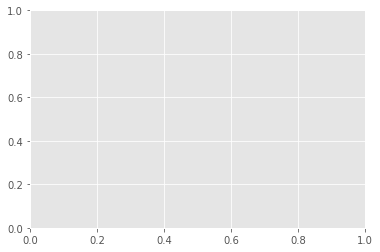

In [48]:
colors = [ '#66CDAA',  '#6495ED']


df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Claim.value_counts())

df_test_over.Claim.value_counts().plot(kind='bar', title='Count (target)',colors=colors);

In [50]:
#Convertin the predictor variable in a binary numeric variable
df_test_over['Claim'].replace(to_replace='Yes', value=1, inplace=True)
df_test_over['Claim'].replace(to_replace='No',  value=0, inplace=True)
df_test_over.head()

Feature = df_test_over[['Duration', 'Distribution.Channel', 'Net.Sales',  'Age']]
Feature = pd.concat([Feature,pd.get_dummies(df_test_over['Distribution.Channel'])], axis=1)
X = Feature[['Duration', 'Net.Sales', 'Age', 'Offline','Online']]
X

from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

# Target label, 
y = df_test_over['Claim']
y


8        0
9        0
10       0
11       0
13       0
        ..
10090    1
3099     1
12167    1
9428     1
15052    1
Name: Claim, Length: 35334, dtype: int64

In [51]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 89.88%


In [52]:
# from sklearn.metrics import confusion_matrix
# from matplotlib import pyplot as plt

# conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
# print('Confusion matrix:\n', conf_mat)

# labels = ['Class 0', 'Class 1']
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
# fig.colorbar(cax)
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
# plt.xlabel('Predicted')
# plt.ylabel('Expected')
# plt.show()

Since we get better results with over sampling data set we will contiune this practice session using it.

Classification Metrics: 
1. Accuracy
2. Confusion Matrix
3. Precision / Recall
4. F1 score
5. AUC
6. LogLoss
7. KFold


## 2. Confusion matrix:

1. A **confusion matrix**, on the other hand, will make the distinction between the number of samples that were correctly classified as non terrorists and those that were correctly classified as terrorists. A confusion matrix is split into 4 quadrants.

    * `True Positive:`
        * Interpretation: You predicted positive and it’s true.
        * You predicted that the person is a terrorist and they actually are.

    * `True Negative:`
        * Interpretation: You predicted negative and it’s true.
        * You predicted that the person is not a terrorist and they’re actually are not.

    * `False Positive: (Type 1 Error)`
        * Interpretation: You predicted positive and it’s false.
        * You predicted that the person is a terrorist but they actually are not.

    * `False Negative: (Type 2 Error)`
        * Interpretation: You predicted negative and it’s false.
        * You predicted that the person is not a terrorist but they actually are.

Confusion matrix:
 [[4596  746]
 [ 327 4932]]


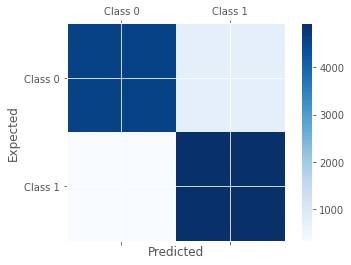

In [54]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

## 3. Precision / Recall

* Sometimes, it’s easier to evaluate a model’s performance using numbers rather than relying on a library to visualize a confusion matrix.


* In the real world, you’ll encounter classification problems where the dividing line forces you to select between having a `high precision` or a `high recall`. 


* In certain circumstances, it’s better to have `a high precision`. For example, a diagnosis might be better off with `a few false positives` rather than let anyone with the actual disease slip through the cracks and avoid getting treated. 

* Other times, it’s better to have `a higher recall` as is the case in spam filters. It’s more acceptable to have a few spam emails in the user’s inbox than it is to classify important emails as junk. 


* We can represent the tradeoff between precision and recall graphically in order to form a better judgement.

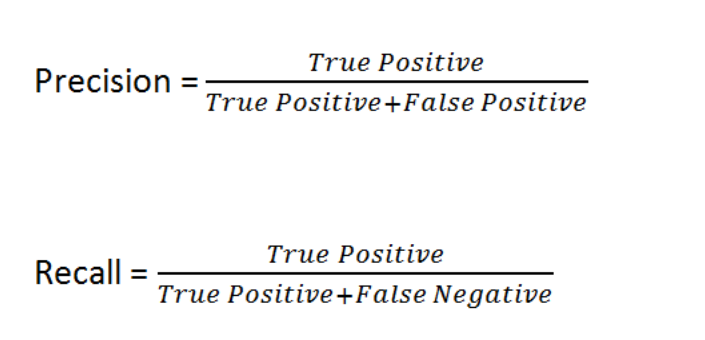

In [94]:
from IPython.display import Image
Image(filename='pre_rec.png') 

# source: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

Average precision-recall score: 0.85


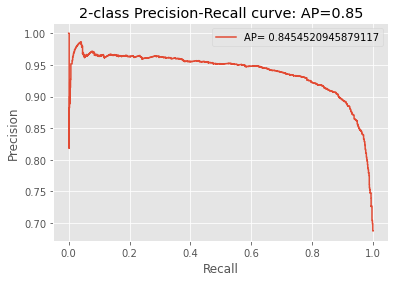

In [55]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(model, X_test, y_test,label="AP= "+str(average_precision))
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.legend()

## 4. F1 Score

* Going back to our example of the spam detector. If the precision is equal to 100% and the recall is equal to 0% then the `harmonic mean` is equal to 0%. We call this value the `F1 Score`.

* Rather than measure recall and then precision every time, it would be easier if we could use a single score. At first, we might try taking the average of the two results.

    * For example, say a spam detector had a precision of 80% and a recall of 37% then the average would be 58.5%. Now, say we built spam detector that didn’t treat any emails as spam (analogous to the terrorist example). In the event there are significantly more emails that aren’t spam than spam, our model will be interpreted as having an ok performance.
    
        * To elaborate, if 300,000 emails are ham (not spam) and 500 are spam then a model that classified all emails as ham would obtain `a precision of 100% since it correctly classified all ham` and a `recall of 0% since it incorrectly classified all spam`.
        
    * If we took the average, we’d still get 50% which is somewhat misleading since the entire purpose of the spam detector is to detect spam.


* It’s for the preceding reason that we make use of the harmonic mean instead of the arithmetic mean to compute the average. The harmonic mean is always closer to the smaller number than the higher number.

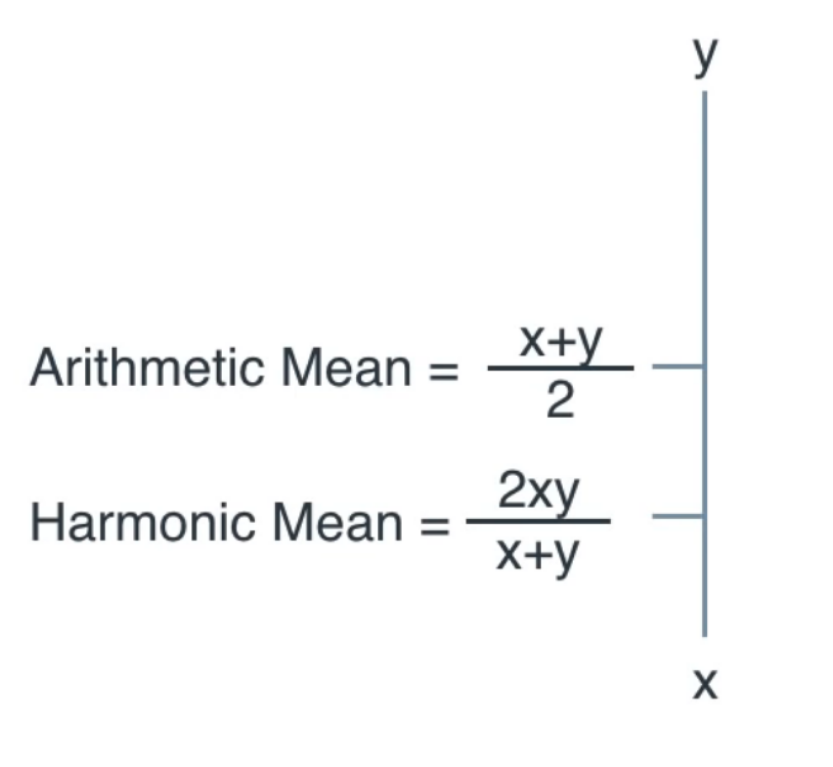

In [96]:
from IPython.display import Image
Image(filename='fscore.png') 

# source: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

In [56]:
from sklearn.metrics import f1_score

print(f"F1_score macro: {f1_score(y_test, y_pred, average='macro')}")
print(f"\nF1_score micro: {f1_score(y_test, y_pred, average='micro')}")
print(f"\nF1_score weighted: {f1_score(y_test, y_pred, average='weighted')}")


F1_score macro: 0.8986813508941816

F1_score micro: 0.8987831336666352

F1_score weighted: 0.8986562081259862


## 5. ROC / AUC

* Similarly to the precision/recall curve, the Receiver Operator Characteristic (ROC) graph provides an elegant way of presenting multiple confusion matrices produced at different thresholds. A ROC plots the relationship between the `true positive rate and the false positive rate.`

1. **True positive rate =** `Recall` = `Sensitivity` = true positive / (true positive + false negative)
2. **False positive rate =** 1 – `specificity` = false positive / (false positive + true negative)

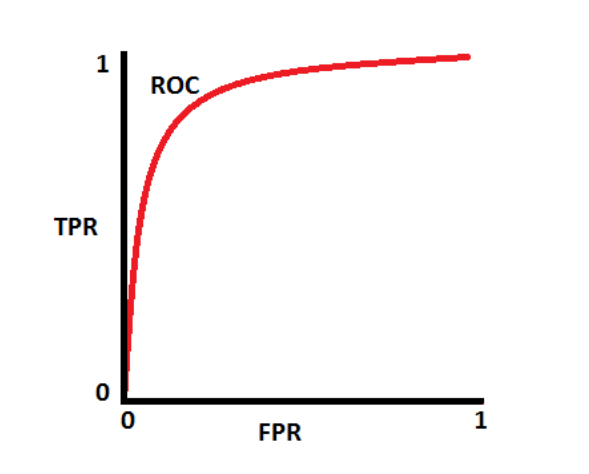

In [98]:
from IPython.display import Image
Image(filename='auc.png') 

# source: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

* It’s important to note that the false positive rate is 1 minus the specificity which means that the closer the false positive rate is to 0 the higher the `specificity (recall)`. Therefore, `to obtain the optimal values for specificity and sensitivity, we’ll want to select a point in the top left corner.`

* On the other hand, the `Area Under the Curve (AUC)` makes it easy to compare one ROC curve to another. the model associated with the red curve achieves a higher sensitivity for the same amount of specificity.

In [57]:
probs = model.predict_proba(X_test)
pd.DataFrame(probs)

,0,1
0,0.845302,0.154698
1,0.963624,0.036376
2,0.109360,0.890640
3,0.232874,0.767126
4,0.227918,0.772082
...,...,...
10596,0.801724,0.198276
10597,0.644010,0.355990
10598,0.646312,0.353688
10599,0.877687,0.122313


The `roc_curve` method expects a single feature. Therefore, we take the predicted probabilities that a tumor is malignant.

In [58]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from inspect import signature

In [59]:
class_1_probs = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, class_1_probs)
roc_auc = auc(fpr, tpr)

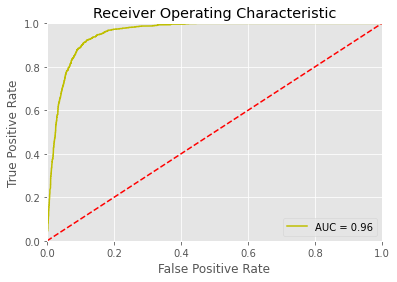

In [60]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'y', label = 'AUC = %0.2f' % roc_auc, )
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As a quick reminder, precision measures true positives over true positives plus false positives.

In [61]:
precision_score(y_test, y_pred)

0.8686157097569567

Recall measures true positives over true positives plus false negatives.

In [62]:
recall_score(y_test, y_pred)

0.9378208784940103

The F1 score combines precision and recall using the harmonic mean.

In [63]:
f1_score(y_test, y_pred)

0.9018926579500777

Selecting the number of thresholds which correspond to the top right corner will result in the best combination of precision and recall.

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.85')

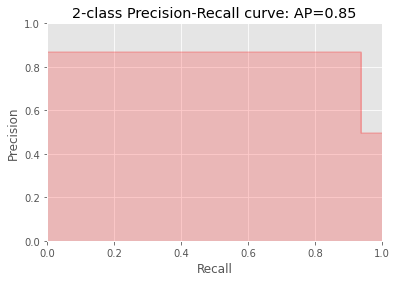

In [64]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.step(recall, precision, color='r', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='r', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

## 6. Log Loss Score

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

* **Log loss**, also called `logistic loss` `logarithmic loss,` or `cross entropy` can be used as a measure for evaluating predicted probabilities.


* Each predicted probability is compared to the actual class output value (0 or 1) and a score is calculated that penalizes the probability based on the distance from the expected value. The penalty is logarithmic, offering a small score for small differences (0.1 or 0.2) and enormous score for a large difference (0.9 or 1.0).

* A model with perfect skill has a log loss score of `0.0.`


* In order to summarize the skill of a model using log loss, the log loss is calculated for each predicted probability, and the average loss is reported.

In [65]:
from sklearn.metrics import log_loss


# predict probabilities
probs = model.predict_proba(X_test)

# keep the predictions for class 1 only
probs = probs[:, 1]

# calculate log loss
loss = log_loss(y_test, probs)
loss

0.2977733614361413

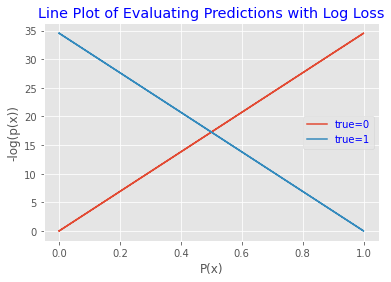

In [66]:

# plot impact of logloss for single forecasts
from sklearn.metrics import log_loss
from matplotlib import pyplot
from numpy import array
import matplotlib

# predictions as 0 to 1 in 0.01 increments
yhat = y_pred

# evaluate predictions for a 0 true value
losses_0 = [log_loss([0], [x], labels=[0,1]) for x in yhat]

# evaluate predictions for a 1 true value
losses_1 = [log_loss([1], [x], labels=[0,1]) for x in yhat]

matplotlib.rcParams.update({'text.color' : "blue",})
                    # 'axes.labelcolor' : "blue"})
# plot input to loss
pyplot.plot(yhat, losses_0, label='true=0')
pyplot.plot(yhat, losses_1, label='true=1')
pyplot.legend()
plt.title('Line Plot of Evaluating Predictions with Log Loss')
plt.xlabel("P(x)")
plt.ylabel("-log(p(x))")
pyplot.show()

## 7. K-Fold



# What is K-Fold Cross Validation?


* Evaluating a Machine Learning model can be quite tricky. Usually, we split the data set into `training` and `testing` sets and use the training set to train the model and testing set to test the model.

* We then evaluate the model performance based on many different metrics to determine the goodness of the model. `This method however, is not very reliable as the accuracy obtained for one test set can be very different to the accuracy obtained for a different test set.`


* **K-fold Cross Validation(CV)** provides a solution to this problem by dividing the data into folds and ensuring that each fold is used as a testing set at some point. 


* **K-Fold CV** is where a given data set is split into a `K number of sections/folds` where each fold is used as a testing set at some point.

* **For example:** lets take the scenario of `5-Fold cross validation(K=5).` Here, the data set is split into 5 folds. In the first iteration, the first fold is used to test the model and the rest are used to train the model. In the second iteration, 2nd fold is used as the testing set while the rest serve as the training set. This process is repeated until each fold of the 5 folds have been used as the testing set.



In [71]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import RepeatedKFold
kf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=None) 

for train_index, test_index in kf.split(X):
      print("Train:", train_index, "Validation:",test_index)
      X_train, X_test = X[train_index], X[test_index] 
      y_train, y_test = y[train_index], y[test_index]

Train: [    1     2     3 ... 35331 35332 35333] Validation: [    0     4     6 ... 35320 35327 35330]


KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [68]:
from sklearn.model_selection import cross_val_score

clf = XGBClassifier()

scores = cross_val_score(clf, X, y, cv=6)
scores


array([0.91611479, 0.91611479, 0.89794532, 0.89471897, 0.88588895,
       0.85311598])

In [69]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.89 (+/- 0.04)
